# Inaugural Project

**Group members:** Ida Margrethe Stagsted, Julie Danneberg Voss, Ida Marie Krogh Jensen 


Imports and set magics:

In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets
from scipy import optimize

# Import our class
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

When we want to see the $H_F/H_M$ ratio for different values of alpha and sigma we construct a table with the possible 9 values.

In [55]:
# code for solving the model

from HouseholdSpecializationModel import HouseholdSpecializationModelClass as HC

alpha = [0.25, 0.50, 0.75]
sigma = [0.50, 1.00, 1.50]

function = HC() # Her trækker vi på funktionerne eller class

def print_table(alpha, sigma): #her printes en tabel over alpha og sigma
    
    # a. empty text
    text = ''
    
    # b. top header
    text += f'{"":3s}'
    for j, HF in enumerate(sigma):
       text += f'{j:6d}' 
    text += '\n' # line shift
    
    # c. body
    for i, a in enumerate(alpha):
        if i > 0:
            text += '\n' # line shift
        text += f'{i:3d} ' # left header
        for j, s in enumerate(sigma):
            function.par.alpha = a
            function.par.sigma = s
            HM = function.solve_discrete().HM
            HF = function.solve_discrete().HF
            text += f'{HF/HM:6.3f}'
    
    # d. print
    print(text)

print_table(alpha,sigma)



/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:66: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


        0     1     2
  0  0.545 0.308 0.214
  1  1.000 1.000 1.000
  2  1.833 3.250 4.667


# Question 2

Explain your code and procedure

[2.0794415416798357, 1.6094379124341003, 1.540445040947149, 1.540445040947149, 1.466337068793427]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


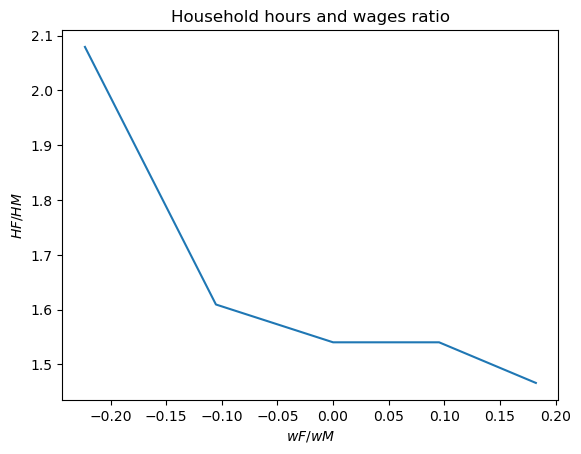

In [56]:
solution_wage = []

HM_wage_vec = ()
HF_wage_vec = ()
wF = (0.8, 0.9, 1.0, 1.1, 1.2)

for wages in wF:
    function.par.wF = wages
    solution_wage.append(function.solve_discrete())

HF_wage_vec = [ns.HF for ns in solution_wage]
HM_wage_vec = [ns.HM for ns in solution_wage]

H_ratio = [np.log(HF_ny/HM_ny) for HF_ny,HM_ny in zip(HF_wage_vec,HM_wage_vec)]
w_ratio = np.log(wF)

print(H_ratio)
print(w_ratio)


# Vi starter med at lave en figur
def plot_ratio():
    fig = plt.figure() # create the figure

    # Nu laver vi et plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio,H_ratio)

    # b. add labels
    ax.set_title('Household hours and wages ratio')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

plot_ratio()


# Question 3

Explain your code and procedure

In [62]:
solution_con = []

wF = (0.8, 0.9, 1.0, 1.1, 1.2)

for wages in wF:
    function_1 = HouseholdSpecializationModelClass()
    function_1.par.wF = wages
    solution_con.append(function_1.solve_con())

HF_wage_vec_con = [ns[3] for ns in solution_con]
HM_wage_vec_con = [ns[2] for ns in solution_con]

H_ratio_con = [np.log(HF_a/HM_a) for HF_a, HM_a in zip(HF_wage_vec_con,HM_wage_vec_con)]
w_ratio_con = np.log(wF)

print(H_ratio_con)
print(w_ratio_con)


[0.22389861355553367, 0.1051875047989173, 0.0, -0.09292485638856358, -0.18292808602212512]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


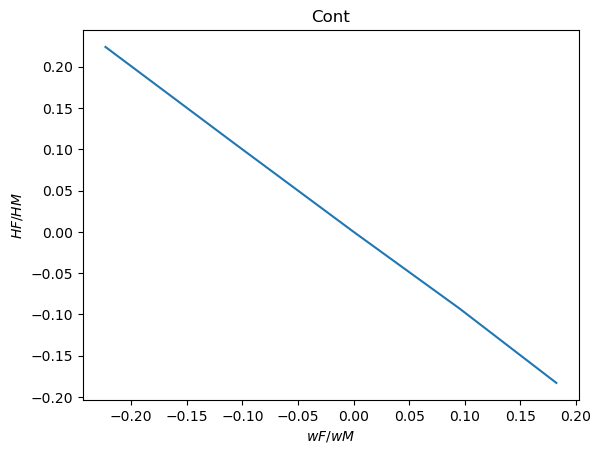

In [63]:
def plot_cont():
    fig = plt.figure() # create the figure

    # Nu laver vi et plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio_con,H_ratio_con)

    # b. add labels
    ax.set_title('Cont')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

plot_cont()

# Question 4

Explain your code and procedure

In [ ]:
# Code for question 4

# Question 5

Explain your code and procedure

In [ ]:
# Code for question 5